In [1]:
import numpy as np
from scipy.stats import norm
from tqdm import tqdm_notebook as tqdm
from functools import partial
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# p_given_d distribution parameters
d_mean = 3
d_std = 8
max_prob = 0.3

# point parameters
num_points = 30000
num_show = 500
grid_size = 150

In [3]:
def generate_points(num_points, grid_size):
    points = np.random.rand(num_points, 2)
    points = grid_size * points.astype(np.float32)
    return points

def calc_num_pairs(num_points):
    num_pairs = num_points * (num_points - 1) / 2
    return num_pairs

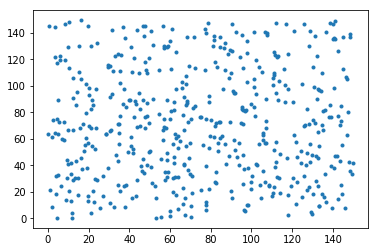

In [4]:
points = generate_points(num_points, grid_size)
plt.plot(points[:num_show,0], points[:num_show,1], '.')

In [5]:
def calculate_pariwise_distances(points1, points2):
    diff_x = points1[np.newaxis,:,0] - points2[:,0,np.newaxis]
    diff_y = points1[np.newaxis,:,1] - points2[:,1,np.newaxis]
    diff = np.sqrt(diff_x**2 + diff_y**2)
    return diff


def batch_calculate_pariwise_distances(points,
                                       max_pairs_per_calculation=10000**2):
    num_points = len(points)
    diff = np.zeros((num_points, num_points), dtype=points.dtype)
    diff[:] = np.nan
    
    batch_size = int(max_pairs_per_calculation / num_points)
    num_batches = int(np.ceil(num_points / float(batch_size)))
    for i_batch in tqdm(range(num_batches)):
        i_start = i_batch * batch_size
        i_end = (i_batch + 1) * batch_size
        points_batch = points[i_start:i_end]
        diff_batch = calculate_pariwise_distances(points, points_batch)
        diff[i_start:i_end, :] = diff_batch
    return diff


def test_batch_diff():
    # Arange
    points = np.random.rand(100,2).astype(np.float32)
    max_pairs_per_calculation = 100 * 13

    # Act
    batch_dist = batch_calculate_pariwise_distances(
        points, max_pairs_per_calculation)
    single_dist = calculate_pariwise_distances(points, points)
    
    # Assert
    return np.allclose(batch_dist, single_dist)


test_batch_diff()

True

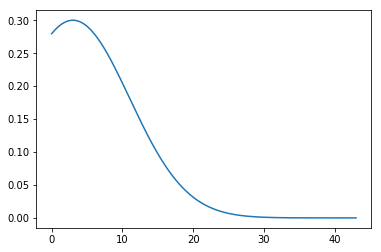

In [6]:
def elementwise_calculate_probabilities_gaussian(distances, d_mean, d_std, max_prob=1.):
    normalization_factor = max_prob / norm.pdf(d_mean, loc=d_mean, scale=d_std)
    probs = norm.pdf(distances, loc=d_mean, scale=d_std) * normalization_factor
    probs = probs.astype(distances.dtype)
    return probs


def elementwise_calculate_probabilities_threshold_function(distances, d_mean, d_std):
    thresh = d_mean + 2 * d_std
    probs = distances < thresh
    probs = probs.astype(distances.dtype)
    return probs


elementwise_calculate_probabilities = partial(elementwise_calculate_probabilities_gaussian, max_prob=max_prob)


def calculate_probability_matrix(distances_matrix, d_mean, d_std):
    probs = np.zeros_like(distances_matrix)
    probs[:] = np.nan
    num_rows = len(probs)
    
    for i_row in range(num_rows):
        probs[i_row] = elementwise_calculate_probabilities(
            distances_matrix[i_row], d_mean, d_std)
        
    probs[range(num_rows),range(num_rows)] = 0
    return probs


def test_matrix_calc_probabilities():
    # Arange
    d_mean, d_std = 0., 3.
    points = np.random.rand(100,2).astype(np.float32)
    diff = calculate_pariwise_distances(points, points)
    
    # Act
    elementwise = elementwise_calculate_probabilities(diff, d_mean, d_std)
    elementwise[range(len(elementwise)),range(len(elementwise))] = 0
    rowwise = calculate_probability_matrix(diff, d_mean, d_std)
    
    # Assert
    return np.allclose(elementwise, rowwise)


def plot_theoretical_distribution(d_mean, d_std):
    d_linspace = np.linspace(0, d_mean + 5 * d_std, 1000)
    p_together_given_d = elementwise_calculate_probabilities(d_linspace, d_mean, d_std)
    plt.plot(d_linspace, p_together_given_d)


test_matrix_calc_probabilities()
plot_theoretical_distribution(d_mean, d_std)

In [7]:
diff = batch_calculate_pariwise_distances(points)
diff.shape

(30000, 30000)

In [8]:
probs = calculate_probability_matrix(diff, d_mean, d_std)

In [9]:
def sample_togetherness(probs):
    together = np.zeros(probs.shape, dtype=bool)
    for i_row in range(len(probs)):
        probs_row = probs[i_row]
        uniform_rand = np.random.rand(*probs_row.shape)
        together_row = uniform_rand < probs_row
        together[i_row] = together_row
    return together

In [10]:
together = sample_togetherness(probs)

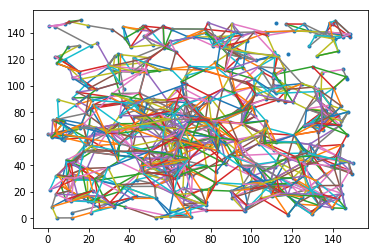

In [11]:
together_i, together_j = np.nonzero(together[:num_show,:num_show])

x_i = points[together_i, 0]
x_j = points[together_j, 0]
y_i = points[together_i, 1]
y_j = points[together_j, 1]
x_ij = np.vstack([x_i, x_j])
y_ij= np.vstack([y_i, y_j])

plt.plot(points[:num_show,0], points[:num_show,1], '.')
plt.plot(x_ij, y_ij)
plt.show()

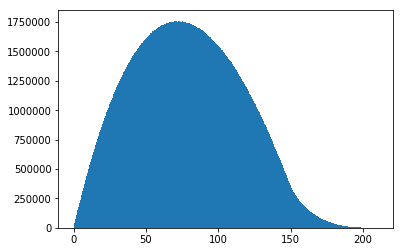

In [12]:
bins = 1000

not_diag = ~np.diag(np.ones(num_points, dtype=bool))
diff_no_self_loops = diff[not_diag]
p_d, hist_edges, _ = plt.hist(diff_no_self_loops, bins=bins)
p_d /= calc_num_pairs(num_points)

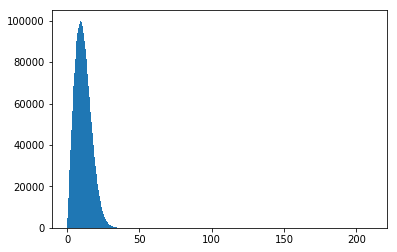

In [13]:
together_diffs = diff[together]
p_together_and_d, _, _ = plt.hist(together_diffs, bins=hist_edges)
p_together_and_d /= calc_num_pairs(num_points)

<BarContainer object of 1000 artists>

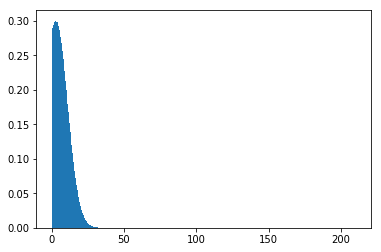

In [14]:
p_empiric_together_given_d = p_together_and_d / p_d
bin_width = hist_edges[1] - hist_edges[0]
plt.bar(hist_edges[:-1], p_empiric_together_given_d, align="edge", width=bin_width)

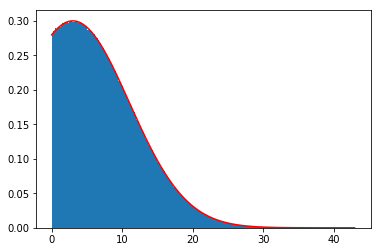

In [15]:
relevant_edges = hist_edges[hist_edges < d_mean + d_std * 5]
relevant_p_empiric_together_given_d = p_empiric_together_given_d[hist_edges[:-1] < d_mean + d_std * 5]
plt.bar(relevant_edges, relevant_p_empiric_together_given_d,
        align="edge", width=bin_width)
plt.plot(relevant_edges, elementwise_calculate_probabilities(relevant_edges, d_mean, d_std), color="red")